In [ ]:
!nvidia-smi

Mon Jan  4 11:36:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# thanhlt9981
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/models/

/content/drive/MyDrive/models


In [ ]:
!git clone https://github.com/thanhlt998/mrc-ner.git

Cloning into 'mrc-ner'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 115 (delta 53), reused 90 (delta 28), pack-reused 0
Receiving objects: 100% (115/115), 58.90 KiB | 350.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
%cd mrc-ner

/content/drive/MyDrive/models/mrc-ner


In [ ]:
!wget -O data.zip https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/Ee7SM-TG9lhDm1wckP6px0EBE9KxYRuv2ga4TMuiUZKE2g?download=1

--2021-01-04 09:26:33--  https://husteduvn-my.sharepoint.com/:u:/g/personal/thanh_lt163705_sis_hust_edu_vn/Ee7SM-TG9lhDm1wckP6px0EBE9KxYRuv2ga4TMuiUZKE2g?download=1
Resolving husteduvn-my.sharepoint.com (husteduvn-my.sharepoint.com)... 13.107.136.9
Connecting to husteduvn-my.sharepoint.com (husteduvn-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/thanh_lt163705_sis_hust_edu_vn/Documents/data/ner_data/mrc/data.zip?originalPath=aHR0cHM6Ly9odXN0ZWR1dm4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdGhhbmhfbHQxNjM3MDVfc2lzX2h1c3RfZWR1X3ZuL0VlN1NNLVRHOWxoRG0xd2NrUDZweDBFQkU5S3hZUnV2MmdhNFRNdWlVWktFMmc_cnRpbWU9NkZRTjFKS3cyRWc [following]
--2021-01-04 09:26:34--  https://husteduvn-my.sharepoint.com/personal/thanh_lt163705_sis_hust_edu_vn/Documents/data/ner_data/mrc/data.zip?originalPath=aHR0cHM6Ly9odXN0ZWR1dm4tbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdGhhbmhfbHQxNjM3MDVfc2lzX2h1c3RfZWR1X3ZuL0VlN1NNLVRHOWxoRG0xd2NrUDZwe

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/ace2004/
  inflating: data/ace2004/mrc-ner.dev  
  inflating: data/ace2004/mrc-ner.test  
  inflating: data/ace2004/mrc-ner.train  
   creating: data/vlsp_processed/
  inflating: data/vlsp_processed/dev.jsonl  
  inflating: data/vlsp_processed/test.jsonl  
  inflating: data/vlsp_processed/train.jsonl  


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install fastai --upgrade

# Import lib, modules

In [ ]:
import torch
from datasets.mrc_ner_dataset_vlsp_fastai import SentenceTransform, YTransform, BeforeBatchTransform
from utils.read_file import load_jsonl
from transformers import PhobertTokenizer
from fastai.text.all import (
    Datasets,
    tensor,
    Learner, Callback, store_attr, NativeMixedPrecision,
    EarlyStoppingCallback, SaveModelCallback, ReduceLROnPlateau, 
    CSVLogger,
    GradientAccumulation,
    RAdam,
)
import os
from models.phobert_query_ner import PhoBertQueryNER, splitter
from models.query_ner_config import PhobertQueryNerConfig
from loss.loss_func_fastai import CustomLoss
from metrics.query_span_f1_fastai import QuerySpanF1

# Config

In [ ]:
# Config
bert_model = 'vinai/phobert-base'
bert_dropout = 0.1
mrc_dropout = 0.3
loss_type = 'bce'   # bce, dice
flat_ner = False
span_loss_candidates = 'pred_and_gold' # all, pred_and_gold, gold
max_length = 210
batch_size = 10
weight_decay = 0.01
weight_start = 1.0
weight_end = 1.0
weight_span = 0.1
data_dir = 'data/vlsp_processed'

# Data

## Load data

In [ ]:
train_data = load_jsonl(os.path.join(data_dir, 'train.jsonl'))
valid_data = load_jsonl(os.path.join(data_dir, 'dev.jsonl'))
test_data = load_jsonl(os.path.join(data_dir, 'test.jsonl'))

## Data Pipeline

In [ ]:
train_valid_data = [*train_data, *valid_data]
n_samples = len(train_valid_data)

In [ ]:
splits = (list(range(len(train_data))), range(len(train_data), n_samples))

In [ ]:
tokenizer = PhobertTokenizer.from_pretrained(bert_model)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
sent_tfms = SentenceTransform(
    tokenizer=tokenizer,
    possible_only=False,
)

In [ ]:
# data = [sent_tfms(i) for i in train_valid_data]

In [ ]:
# test_data = [sent_tfms(i) for i in test_data]

### Save data

In [ ]:
# torch.save(data, 'train_valid_data.pkl')
# torch.save(test_data, 'test_data.pkl')

### Load saved data

In [ ]:
data = torch.load('train_valid_data.pkl')
test_data = torch.load('test_data.pkl')

## Dataset

In [ ]:
def get_token_ids(x):
    return x['token_ids']
x_tfms = [get_token_ids, tensor]
y_tfms = [YTransform()]
ds = Datasets(
    data,
    splits=splits,
    tfms=[x_tfms, y_tfms],
    n_inp=1,
)

In [ ]:
# ds[0], ds.show(ds[0])

## Dataloader

In [ ]:
def get_dls(ds, bs=8,):
    return ds.dataloaders(
        bs=bs,
        before_batch=BeforeBatchTransform(
            max_seq_length=max_length,
            pad_fields=[0, 1, 2, 3, 4],
            pad_values=[tokenizer.pad_token_id, 0, 0, 0, 0],
            pad_token_id=tokenizer.pad_token_id,
            sep_token_id=tokenizer.sep_token_id,
        ),
        n_inp=1,
        verbose=5,
    )

In [ ]:
dls = get_dls(ds, batch_size)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatchTransform
Setting up after_batch: Pipeline: 


In [ ]:
# dls.one_batch()

# Model

In [ ]:
class WrapperPhoBertQueryNER(PhoBertQueryNER):
    def forward(self, tokens):
        attention_mask = (tokens != self.pad_token_id).long()
        return super().forward(input_ids=tokens, token_type_ids=None, attention_mask=attention_mask)

# Callback

In [ ]:
class GradientClip(Callback):
    "Clip norm of gradients"
    order=11
    def __init__(self,max_norm:float=1., norm_type:float=2.0): store_attr()
    def before_step(self): nn.utils.clip_grad_norm_(self.parameters(), self.max_norm, self.norm_type)


# Training

In [ ]:
model_config = PhobertQueryNerConfig.from_pretrained(
    bert_model,
    hidden_dropouy_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
    mrc_dropout=mrc_dropout,
)

In [ ]:
model = WrapperPhoBertQueryNER.from_pretrained(bert_model, config=model_config)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing WrapperPhoBertQueryNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing WrapperPhoBertQueryNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WrapperPhoBertQueryNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WrapperPhoBertQueryNER were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['start_outputs.weight', 'start_outputs.bias', 'end_outputs.weight', 'end_outputs.bias', 'span_embeddi

In [ ]:
loss_func = CustomLoss(
    weight_start=weight_start,
    weight_end=weight_end,
    weight_span=weight_span,
    span_loss_candidates=span_loss_candidates,
    loss_type=loss_type,
)

In [ ]:
learner = Learner(
    dls=dls,
    model=model,
    loss_func=loss_func,
    opt_func=RAdam,
    splitter=splitter,
    metrics=[QuerySpanF1(flat=flat_ner),],
    cbs=[
        EarlyStoppingCallback(
            monitor='query_span_f1',
            min_delta=1e-4,
            patience=10,
        ),
        SaveModelCallback(
            monitor='query_span_f1',
            min_delta=1e-4,
            fname='best_query_span_f1_model',
            with_opt=True,
        ),
        ReduceLROnPlateau(monitor='valid_loss', min_delta=1e-4, patience=2),
        GradientAccumulation(n_acc=32),
        GradientClip(max_norm=1., norm_type=2.0,),
        CSVLogger(),
    ],
    wd=weight_decay,
)

## Freeze Roberta

In [ ]:
learner.freeze_to(-1)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.04786301031708717)

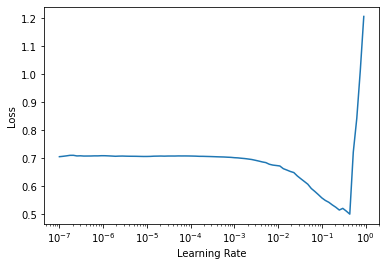

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,query_span_f1,time
0,0.027581,0.024263,0.790674,14:32
1,0.019686,0.018237,0.861990,14:29


Better model found at epoch 0 with query_span_f1 value: 0.7906743288040161.
Better model found at epoch 1 with query_span_f1 value: 0.8619901537895203.


## Unfreeze

In [ ]:
learner.load('best_query_span_f1_model')

In [ ]:
learner.dls = get_dls(ds, 8)

Setting up after_item: Pipeline: 
Setting up before_batch: Pipeline: BeforeBatchTransform
Setting up after_batch: Pipeline: 


In [ ]:
for cb in learner.cbs:
    if type(cb) is SaveModelCallback:
        cb.fname = 'best_query_span_f1_model_unfreezed'

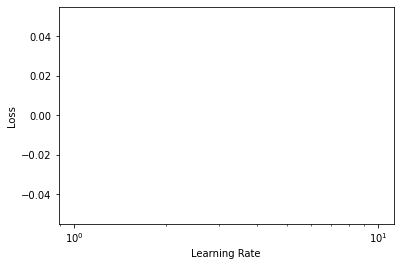

In [ ]:
learner.unfreeze()
learner.lr_find()

In [ ]:
lr = 5e-5
learner.fit_one_cycle(20, slice(lr / (2.6 **4), lr))

epoch,train_loss,valid_loss,query_span_f1,time
0,0.020580,0.017088,0.868118,17:36
1,0.014768,0.014494,0.881397,17:38
2,0.014994,0.013622,0.893334,17:37
3,0.014358,0.012006,0.909479,17:36
4,0.017818,0.010342,0.916929,17:36
5,0.007143,0.010597,0.925097,17:36
6,0.008613,0.011422,0.928479,17:36
7,0.006563,0.009565,0.926283,17:36
8,0.007143,0.012160,0.933068,17:31
9,0.005761,0.011050,0.938787,17:31


Better model found at epoch 0 with query_span_f1 value: 0.868118166923523.
Better model found at epoch 1 with query_span_f1 value: 0.8813967108726501.
Better model found at epoch 2 with query_span_f1 value: 0.8933342099189758.
Better model found at epoch 3 with query_span_f1 value: 0.9094786047935486.
Better model found at epoch 4 with query_span_f1 value: 0.9169294834136963.
Better model found at epoch 5 with query_span_f1 value: 0.9250966906547546.
Better model found at epoch 6 with query_span_f1 value: 0.9284788966178894.
Epoch 6: reducing lr to 4.783892106019353e-06
Better model found at epoch 8 with query_span_f1 value: 0.9330684542655945.
Better model found at epoch 9 with query_span_f1 value: 0.9387867450714111.
Epoch 9: reducing lr to 3.750068784234772e-06
Better model found at epoch 11 with query_span_f1 value: 0.9389450550079346.
Epoch 11: reducing lr to 2.761407777272366e-06
Better model found at epoch 13 with query_span_f1 value: 0.9391496181488037.
Epoch 13: reducing lr to

In [ ]:
learner.export('mrc_ner_model_f18903.pkl')

# Test

In [ ]:
learner.load('best_query_span_f1_model_unfreezed')

In [ ]:
test_dl = learner.dls.test_dl(test_data, with_labels=True)

In [ ]:
test_dl.one_batch()

In [ ]:
learner.validate(dl=learner.dls.valid)

(#2) [0.015297063626348972,0.9398037195205688]

In [ ]:
learner.validate(dl=test_dl)

(#2) [0.025697126984596252,0.8903325200080872]